# Fake News Classification using Machine Learning Algorithms

- Dataset : https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

- Technical Report :


In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Load kaggle dataset directly : https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/
!pip install -q kaggle  
!mkdir ~/.kaggle  
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json  
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [3]:
path = "/content/gdrive/MyDrive/Fake-news-dataset"
fake = pd.read_csv(path + "/Fake.csv")
true = pd.read_csv(path + "/True.csv")

In [4]:
print("Numbers of True news : ", true.shape[0])
print("Numbers of Fake news : ", fake.shape[0])

Numbers of True news :  21417
Numbers of Fake news :  23481


## Data cleaning and preparation

In [5]:
# Add flag to track fake and true
true['target'] = 'true'
fake['target'] = 'fake'

In [6]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
data.head()

,title,text,subject,date,target
0,"EPA waives requirements on sale, production of...",(Reuters) - The U.S. Environmental Protection ...,worldnews,"September 7, 2017",true
1,Ex-U.S. consumer bureau head Cordray set to ru...,"(Reuters) - Richard Cordray, a Democrat whose ...",politicsNews,"December 4, 2017",true
2,Trump says disappointed about collapse of Obam...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"July 18, 2017",true
3,"Trump to speak with leaders of Russia, Germany...",WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"January 27, 2017",true
4,Canada's Trudeau defends finance minister amid...,OTTAWA (Reuters) - Canadian Prime Minister Jus...,worldnews,"October 18, 2017",true


In [9]:
# Removing the date as we would not use it for detection
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,"EPA waives requirements on sale, production of...",(Reuters) - The U.S. Environmental Protection ...,worldnews,true
1,Ex-U.S. consumer bureau head Cordray set to ru...,"(Reuters) - Richard Cordray, a Democrat whose ...",politicsNews,true
2,Trump says disappointed about collapse of Obam...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,true
3,"Trump to speak with leaders of Russia, Germany...",WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,true
4,Canada's Trudeau defends finance minister amid...,OTTAWA (Reuters) - Canadian Prime Minister Jus...,worldnews,true


In [10]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,(Reuters) - The U.S. Environmental Protection ...,worldnews,true
1,"(Reuters) - Richard Cordray, a Democrat whose ...",politicsNews,true
2,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,true
3,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,true
4,OTTAWA (Reuters) - Canadian Prime Minister Jus...,worldnews,true


In [11]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,(reuters) - the u.s. environmental protection ...,worldnews,true
1,"(reuters) - richard cordray, a democrat whose ...",politicsNews,true
2,washington (reuters) - president donald trump ...,politicsNews,true
3,washington (reuters) - u.s. president donald t...,politicsNews,true
4,ottawa (reuters) - canadian prime minister jus...,worldnews,true


In [12]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [13]:
data.head()

,text,subject,target
0,reuters the us environmental protection agenc...,worldnews,true
1,reuters richard cordray a democrat whose resi...,politicsNews,true
2,washington reuters president donald trump on ...,politicsNews,true
3,washington reuters us president donald trump ...,politicsNews,true
4,ottawa reuters canadian prime minister justin...,worldnews,true


In [14]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
data.head()

,text,subject,target
0,reuters us environmental protection agency iss...,worldnews,true
1,reuters richard cordray democrat whose resigna...,politicsNews,true
2,washington reuters president donald trump tues...,politicsNews,true
3,washington reuters us president donald trump h...,politicsNews,true
4,ottawa reuters canadian prime minister justin ...,worldnews,true


subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


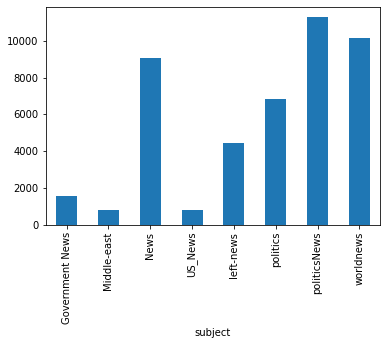

In [16]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


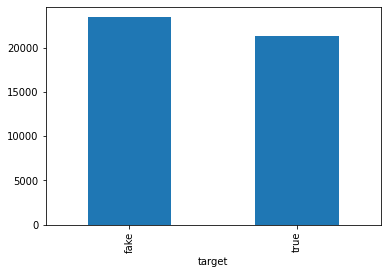

In [17]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

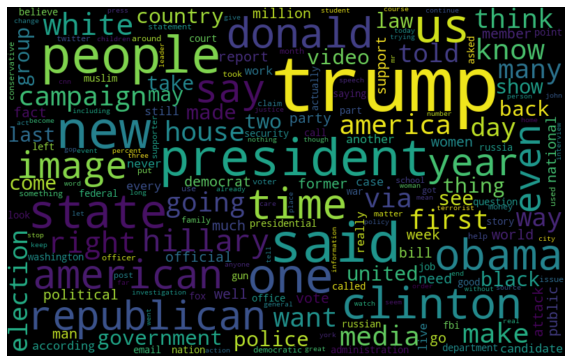

In [18]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

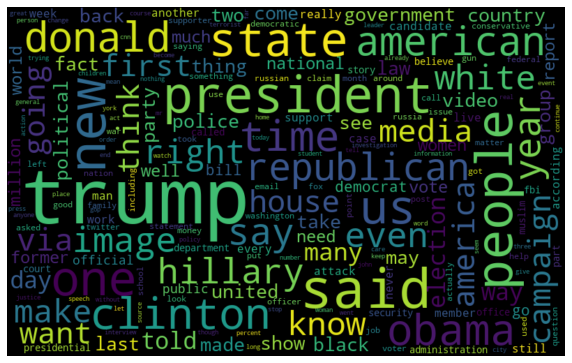

In [19]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
# Tokenization
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

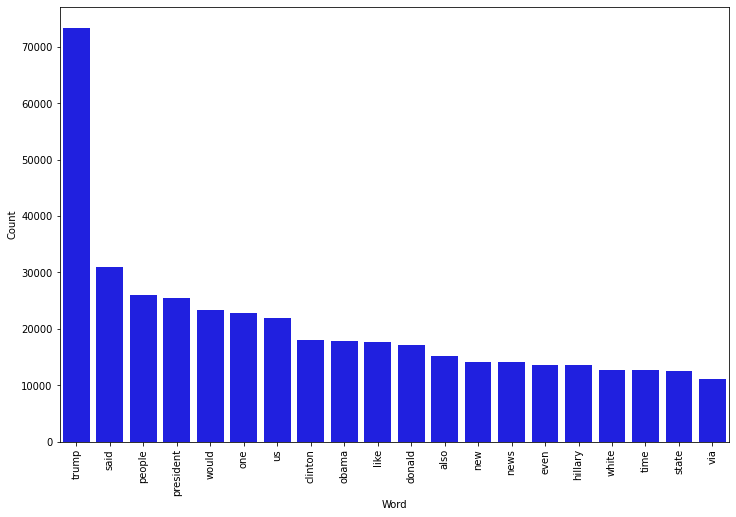

In [21]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

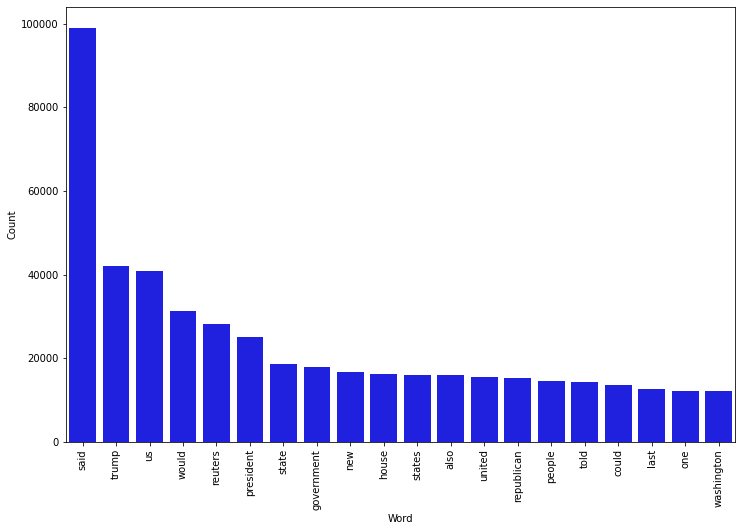

In [22]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modelling with Machine Learning Algorithms

- Naive Bayes
- Logistic Regression
- Decision Tree
- Random Forest 
- Support Vector Machine

In [23]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
# Prepare data - train/test split
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

### Naive Bayes

In [25]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 95.11%


Confusion matrix, without normalization


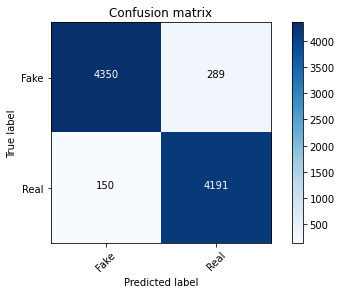

In [26]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Logistic Regression

In [27]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 98.98%


Confusion matrix, without normalization


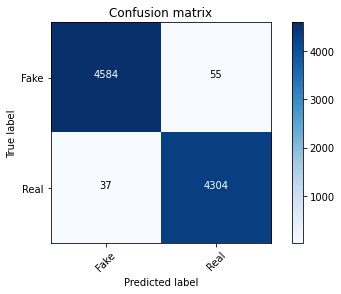

In [28]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.69%


Confusion matrix, without normalization


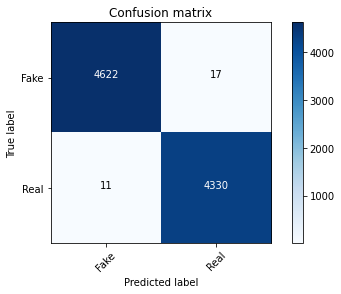

In [30]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 99.04%


Confusion matrix, without normalization


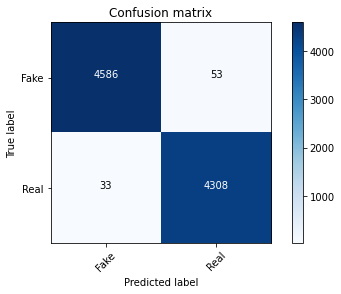

In [32]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Support Vector Machine

- Linear Kernel
- RBF Kernel

In [33]:
from sklearn import svm

#Create a svm Classifier with linear kernel
clf = svm.SVC(kernel='linear') 

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM_linear'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.65%


Confusion matrix, without normalization


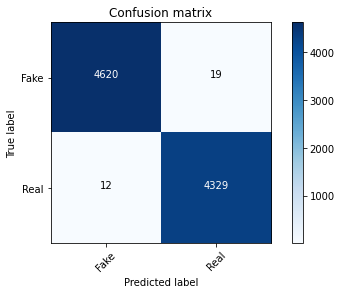

In [34]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [35]:
from sklearn import svm

#Create a svm Classifier with RBF kernel
clf = svm.SVC(kernel='rbf') 

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM_rbf'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.52%


Confusion matrix, without normalization


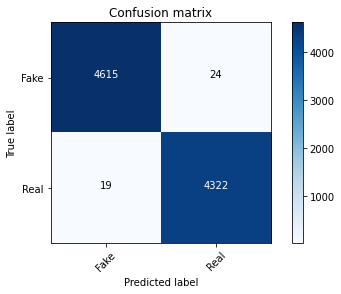

In [36]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## Comparing different machine learning models

([<matplotlib.axis.YTick at 0x7efdfa7ee790>,
 <a list of 10 Text major ticklabel objects>)

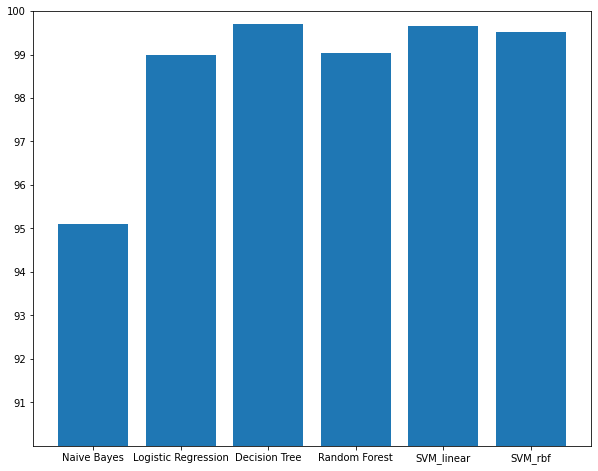

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))